# Keyword-Based News Classification Model ----> Task 


Import the library that we will use .. 

In [41]:
!pip install wordcloud
import sys
print(sys.executable)



C:\Python313\python.exe



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: C:\Users\bbuser\AppData\Local\Programs\Python\Python312\python.exe -m pip install --upgrade pip


In [44]:
import sys
print(sys.executable)


C:\Python313\python.exe


In [45]:
!C:/Python313/python.exe -m pip install wordcloud



In [46]:
from wordcloud import WordCloud

In [40]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np 
from collections import Counter
import matplotlib.pyplot as plt
import re

# 1 -Data Preprocessing

1. Load dataset 

In [10]:
df = pd.read_json("Data/News_Category_Dataset_v3.json", lines=True)



2. Keep only needed columns

In [11]:

df = df[["short_description", "category"]]

In [12]:
df

,short_description,category
0,Health experts said it is too early to predict...,U.S. NEWS
1,He was subdued by passengers and crew when he ...,U.S. NEWS
2,"""Until you have a dog you don't understand wha...",COMEDY
3,"""Accidentally put grown-up toothpaste on my to...",PARENTING
4,Amy Cooper accused investment firm Franklin Te...,U.S. NEWS
...,...,...
209522,Verizon Wireless and AT&T are already promotin...,TECH
209523,"Afterward, Azarenka, more effusive with the pr...",SPORTS
209524,"Leading up to Super Bowl XLVI, the most talked...",SPORTS
209525,CORRECTION: An earlier version of this story i...,SPORTS


 3. Filter only the 4 target categories

In [13]:
categories = ["POLITICS", "TRAVEL", "SPORTS", "HOME & LIVING"]
df = df[df["category"].isin(categories)]

In [14]:
df

,short_description,category
17,"Maury Wills, who helped the Los Angeles Dodger...",SPORTS
21,President issues vow as tensions with China rise.,POLITICS
24,An annual celebration took on a different feel...,POLITICS
26,Las Vegas never had a professional sports cham...,SPORTS
30,"U.S. President Joe Biden, in London for the fu...",POLITICS
...,...,...
209478,"As we stepped out of the serene plantation, we...",TRAVEL
209523,"Afterward, Azarenka, more effusive with the pr...",SPORTS
209524,"Leading up to Super Bowl XLVI, the most talked...",SPORTS
209525,CORRECTION: An earlier version of this story i...,SPORTS


4. Balance dataset: sample 1000 per category

In [15]:
df_balanced = df.groupby("category").apply(lambda x: x.sample(1000, random_state=42)).reset_index(drop=True)

C:\Users\bbuser\AppData\Local\Temp\ipykernel_27576\1468971870.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby("category").apply(lambda x: x.sample(1000, random_state=42)).reset_index(drop=True)


5. Stratified train-test split (80/20)

In [16]:
train_df, test_df = train_test_split(
    df_balanced,
    test_size=0.2,
    stratify=df_balanced["category"],
    random_state=42
)

In [17]:
print("Train size:", train_df.shape)

Train size: (3200, 2)


In [18]:
print("Test size:", test_df.shape)

Test size: (800, 2)


In [19]:
print(train_df["category"].value_counts())

category
TRAVEL           800
SPORTS           800
HOME & LIVING    800
POLITICS         800
Name: count, dtype: int64


In [20]:
print(test_df["category"].value_counts())

category
HOME & LIVING    200
POLITICS         200
TRAVEL           200
SPORTS           200
Name: count, dtype: int64


# 2 – Exploratory Analysis

We need frist simple text cleaner

In [38]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)  # keep only letters
    return text

Apply cleaning

In [47]:
train_df["clean_desc"] = train_df["short_description"].apply(clean_text)

1. Generate word clouds per category

In [48]:
categories = train_df["category"].unique()
for cat in categories:
    text = " ".join(train_df[train_df["category"] == cat]["clean_desc"])
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

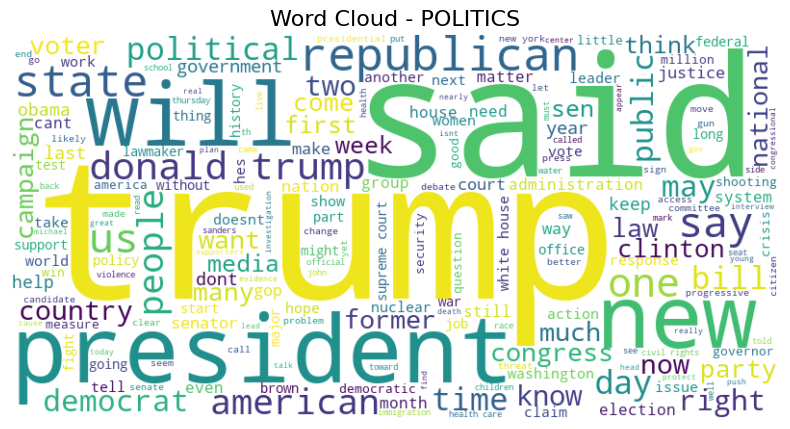

In [49]:
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(f"Word Cloud - {cat}", fontsize=16)
    plt.axis("off")
    plt.show()

2. Extract top frequent words per category

In [50]:
top_words = {}
for cat in categories:
    words = " ".join(train_df[train_df["category"] == cat]["clean_desc"]).split()
    freq = Counter(words)
    most_common = [w for w, _ in freq.most_common(100)]  # top 100 for flexibility
    top_words[cat] = set(most_common)

Just for check

In [51]:
print("Top 10 POLITICS words:", list(top_words["POLITICS"])[:10])

Top 10 POLITICS words: ['had', 'says', 'some', 'the', 'would', 'more', 'when', 'but', 'we', 'do']


# Step 3 – Keyword-Based Classification

clean and tokenize

In [52]:
def clean_and_tokenize(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)   # keep only letters
    return text.split()


Classification function

In [57]:
def classify(text, top_words, n_words=10):
    tokens = clean_and_tokenize(text)
    
    overlaps = {}
    for cat, words in top_words.items():
        overlaps[cat] = len(set(tokens) & set(list(words)[:n_words]))
    
    if all(v == 0 for v in overlaps.values()):
        return "unknown"
    
    max_val = max(overlaps.values())
    best = [k for k, v in overlaps.items() if v == max_val]
    return best[0] if len(best) == 1 else "unknown"

Evaluate classifier on test set

In [58]:
def evaluate_classifier(test_df, top_words, n_words=10):
    preds = test_df["short_description"].apply(lambda x: classify(x, top_words, n_words))
    acc = (preds == test_df["category"]).mean()
    return acc, preds

Check 

In [59]:
acc10, preds10 = evaluate_classifier(test_df, top_words, n_words=10)
print(f"Accuracy with top 10 words: {acc10:.3f}")

Accuracy with top 10 words: 0.049


# Step 4 – Experimentation(Accuracy)

Top 10 words → Accuracy: 0.049
Top 20 words → Accuracy: 0.125
Top 30 words → Accuracy: 0.130
Top 50 words → Accuracy: 0.191
Top 75 words → Accuracy: 0.228
Top 100 words → Accuracy: 0.302


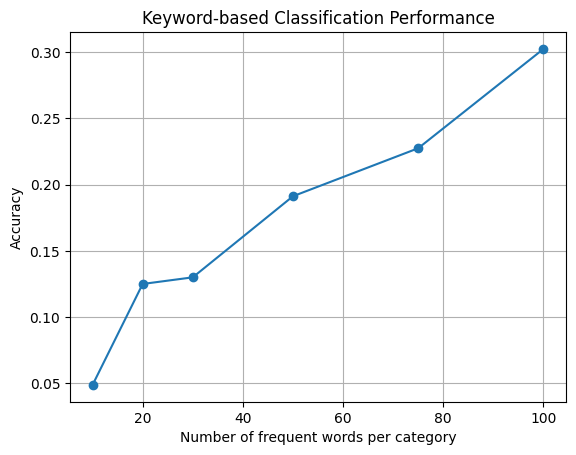

In [60]:
results = {}
for n in [10, 20, 30, 50, 75, 100]:
    acc, _ = evaluate_classifier(test_df, top_words, n_words=n)
    results[n] = acc
    print(f"Top {n} words → Accuracy: {acc:.3f}")


plt.plot(list(results.keys()), list(results.values()), marker="o")
plt.xlabel("Number of frequent words per category")
plt.ylabel("Accuracy")
plt.title("Keyword-based Classification Performance")
plt.grid(True)
plt.show()

Category-wise Analysis

Evaluate with best-performing setup (100 words)

In [61]:
_, preds100 = evaluate_classifier(test_df, top_words, n_words=100)

Replace "unknown" with a placeholder so classification_report works

In [62]:
y_true = test_df["category"]
y_pred = preds100.replace("unknown", "UNKNOWN")

Generate category-level metrics

In [64]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, labels=categories + ["UNKNOWN"]))

                      precision    recall  f1-score   support

       TRAVELUNKNOWN       0.00      0.00      0.00         0
       SPORTSUNKNOWN       0.00      0.00      0.00         0
HOME & LIVINGUNKNOWN       0.00      0.00      0.00         0
     POLITICSUNKNOWN       0.00      0.00      0.00         0

           micro avg       0.00      0.00      0.00         0
           macro avg       0.00      0.00      0.00         0
        weighted avg       0.00      0.00      0.00         0



C:\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Python313\Lib\site-packages\sklearn\metrics\_classification.py

In [65]:

labels = list(categories) + ["UNKNOWN"]

print(classification_report(y_true, y_pred, labels=labels))


               precision    recall  f1-score   support

       TRAVEL       0.60      0.28      0.39       200
       SPORTS       0.61      0.23      0.33       200
HOME & LIVING       0.70      0.34      0.46       200
     POLITICS       0.80      0.35      0.49       200
      UNKNOWN       0.00      0.00      0.00         0

     accuracy                           0.30       800
    macro avg       0.54      0.24      0.33       800
 weighted avg       0.68      0.30      0.42       800



C:\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


This step tells us not just how good the model is overall, but where it succeeds and fails.
It’s crucial for understanding the limitations of a keyword-based classifier and guides the next iteration (e.g., adding better features or moving to machine learning).